In [260]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output




In [261]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 500
batch_size = 5
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


Files already downloaded and verified
Files already downloaded and verified


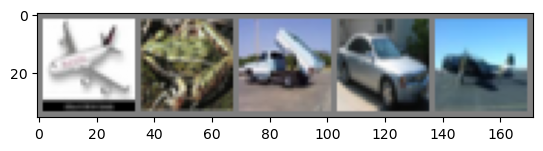

In [262]:

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [263]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x



In [264]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

Epoch [500/500], Test Loss: 6.6743, Test Acc: 61.40%


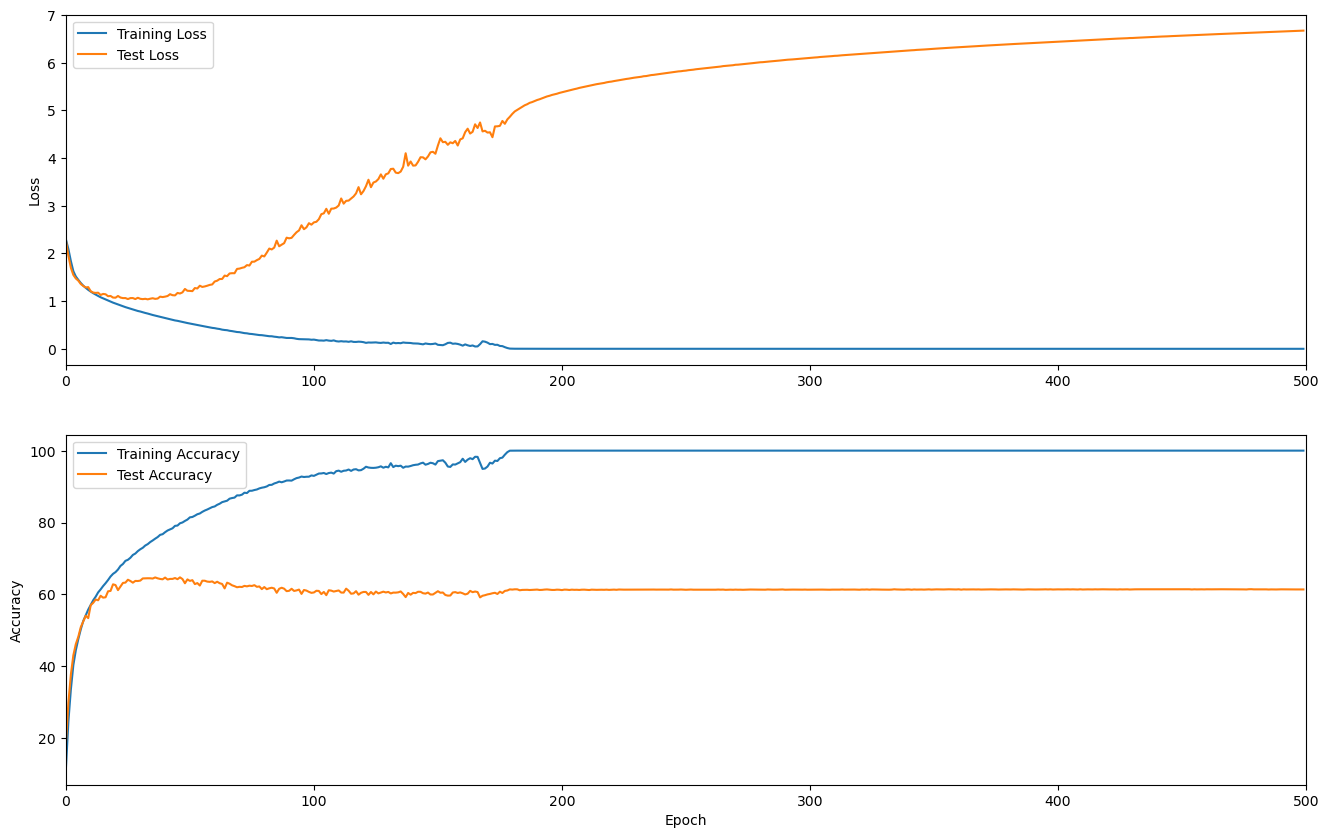

In [265]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    train_loss = 0
    train_total = 0
    epoch_acc = 0
    
    # Set model to train mode
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        epoch_acc += (predicted == labels).sum().item()
        
        if (i+1) % n_total_steps == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Train Loss: {train_loss/train_total:.4f}, Train Acc: {100*epoch_acc/train_total:.2f}%')

    train_losses.append(train_loss/train_total)
    train_accs.append(100*epoch_acc/train_total)

    # Set model to eval mode
    model.eval()
    with torch.no_grad():
        test_loss = 0
        test_total = 0
        test_correct = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update test loss and accuracy
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_losses.append(test_loss/test_total)
        test_accs.append(100*test_correct/test_total)
        clear_output(wait=True) #  clean the console 

        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss/test_total:.4f}, Test Acc: {100*test_correct/test_total:.2f}%')
        
        
        
        plt.figure(figsize=(16,10))


        # Plot training and test losses
        plt.subplot(2, 1, 1)  
        
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.legend()
        plt.ylabel('Loss')
        plt.xlim(0, num_epochs)


        # Plot training and test accuracies
        plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2 (lower plot)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(test_accs, label='Test Accuracy')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.xlim(0, num_epochs)
        

        plt.show()



In [266]:

PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 61.4 %
Accuracy of plane: 66.4 %
Accuracy of car: 75.3 %
Accuracy of bird: 48.0 %
Accuracy of cat: 42.6 %
Accuracy of deer: 52.9 %
Accuracy of dog: 52.3 %
Accuracy of frog: 71.5 %
Accuracy of horse: 66.8 %
Accuracy of ship: 72.4 %
Accuracy of truck: 65.8 %
